In [2]:
"""
Here, we are going to attempt to recreate the plots corresponding to the one-point spectra
F11 (and F22 after that) from Syed Mann (2024) Equation 6, since analytical attempts
have flopped every single time.
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.special as special

# Verification of methodology

First, we are going to verify that the methodology I think is correct is in fact correct by recreating the
plot in Figure 2 Syed-Mann (2024) "theory" paper.

I have previously recreated this plot with the analytical formula, so I know this can be checked.

In [3]:
"""
NOTE: The equations in this cell are from the theory paper, not the simulation paper.
"""

def _calculate_rho(k1, L_2D, psi):
    """
    Calculate equation (18)
    """
    return np.sqrt(1 + 2 * (k1 * L_2D) ** 2 * np.cos(psi) ** 2)


def eq16_analytical_F11_2D(k1, sigma_squared, L_2D, psi):
    """
    Calculate F_11^2D according to equation (16)

    """
    rho = _calculate_rho(k1, L_2D, psi)

    # Calculate the spectrum
    F11 = (
        (sigma_squared * L_2D)
        * ((special.gamma(5 / 6)) / ((2 ** (3 / 2)) * (np.pi ** (1 / 2)) * special.gamma(1 / 3) * (np.sin(psi) ** 3)))
        * (rho ** (-5 / 3))
    )

    return F11


def eq17_analytical_F22_2D(k1, sigma_squared, L_2D, psi):
    """
    Calculate F_22^2D according to equation (17)
    """
    rho = _calculate_rho(k1, L_2D, psi)

    leading_factor = sigma_squared * L_2D
    numerator = 5 * special.gamma(5 / 6)
    denominator = 3 * np.sqrt(2) * np.sqrt(np.pi) * special.gamma(1 / 3) * np.sin(psi)
    trailing_factor = (k1 * L_2D) ** 2 / rho ** (11 / 3)

    return leading_factor * (numerator / denominator) * trailing_factor


def get_normalized_spectra(k1, sigma_squared, L_2D, psi):
    """
    Calculate normalized spectra k1F_ii(k1) for both components
    """
    # Calculate base spectra
    F11 = eq16_analytical_F11_2D(k1, sigma_squared, L_2D, psi)
    F22 = eq17_analytical_F22_2D(k1, sigma_squared, L_2D, psi)

    # Normalize by multiplying with k1
    k1F11 = k1 * F11
    k1F22 = k1 * F22

    return k1F11, k1F22


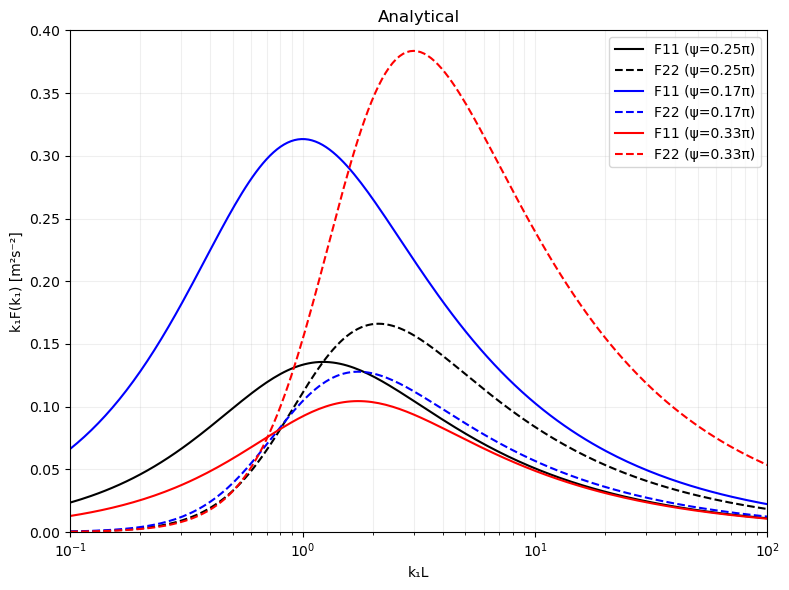

In [4]:
plt.clf(); plt.close('all');

# Generate k1L range (x-axis)
k1L = np.logspace(-1, 2, 200)

# Set parameters
L_2D = 1.0  # Length scale
sigma_squared = 1.0  # Variance

# Define anisotropy parameters
psi_values = {
    "isotropic": np.pi / 4,  # Black lines
    "sigma11_lt_sigma22": np.pi / 6,  # Blue lines
    "sigma11_gt_sigma22": np.pi / 3,  # Red lines
}

# Create figure
plt.figure(figsize=(8, 6))

# Plot spectra for each psi value
colors = {"isotropic": "k", "sigma11_lt_sigma22": "b", "sigma11_gt_sigma22": "r"}

###############################################################
# Plot analytical values
for case, psi in psi_values.items():
    # Calculate normalized spectra
    k1F11, k1F22 = get_normalized_spectra(k1L / L_2D, sigma_squared, L_2D, psi)

    # Plot F11 (solid) and F22 (dashed)
    plt.plot(k1L, k1F11, color=colors[case], linestyle="-", label=f"F11 (ψ={psi/np.pi:.2f}π)")
    plt.plot(k1L, k1F22, color=colors[case], linestyle="--", label=f"F22 (ψ={psi/np.pi:.2f}π)")

# Set plot properties
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Set axis limits to match the paper
plt.xlim(1e-1, 1e2)
plt.ylim(0, 0.4)

plt.title("Analytical")
plt.tight_layout()

plt.show()

In [5]:
"""
Numerical integration method for the one-dimensional spectra.
"""

###################################################
# Helper functions

def _calculate_kappa(k1, k2, psi):
    """
    Calculate kappa from k1 and k2
    """
    return np.sqrt(2 * ((k1 * np.cos(psi))**2 + (k2 * np.sin(psi))**2))

def _general_leading(k1, k2, sigma_squared, L_2D, psi):
    """
    Spectral tensor from eq 15

    Should be leading factor for all spectral tensors
    """
    leading_factor = (
        8 * (sigma_squared * L_2D)**2
    ) / (
        9 * np.pi
    )

    kappa = _calculate_kappa(k1, k2, psi)

    middle_factor = (
        L_2D**2
    ) / (
        (1 + (kappa * L_2D)**2)**(7/3)
    )

    return leading_factor * middle_factor

def integrand_spectral_tensor11(k1, k2, sigma_squared, L_2D, psi):
    """
    Spectral tensor from eq 15

    Should be integrand for anisotropic F11
    """
    return _general_leading(k1, k2, sigma_squared, L_2D, psi) * k2**2

def integrand_spectral_tensor22(k1, k2, sigma_squared, L_2D, psi):
    """
    Spectral tensor from eq 15

    Should be integrand for anisotropic F22
    """
    return _general_leading(k1, k2, sigma_squared, L_2D, psi) * k1**2

###################################################
# Drivers

def eq16_numerical_F11_2D(k1: float, sigma_squared: float, L_2D: float, psi: float) -> float:
    """
    Calculate F_11^2D according to spectral tensor in eq 15
    """
    return integrate.quad(
        lambda k2: integrand_spectral_tensor11(k1, k2, sigma_squared, L_2D, psi),
        -np.inf, np.inf,
    )

def eq17_numerical_F22_2D(k1: float, sigma_squared: float, L_2D: float, psi: float) -> float:
    """
    Calculate F_22^2D according to spectral tensor in eq 15
    """
    return integrate.quad(
        lambda k2: integrand_spectral_tensor22(k1, k2, sigma_squared, L_2D, psi),
        -np.inf, np.inf,
    )



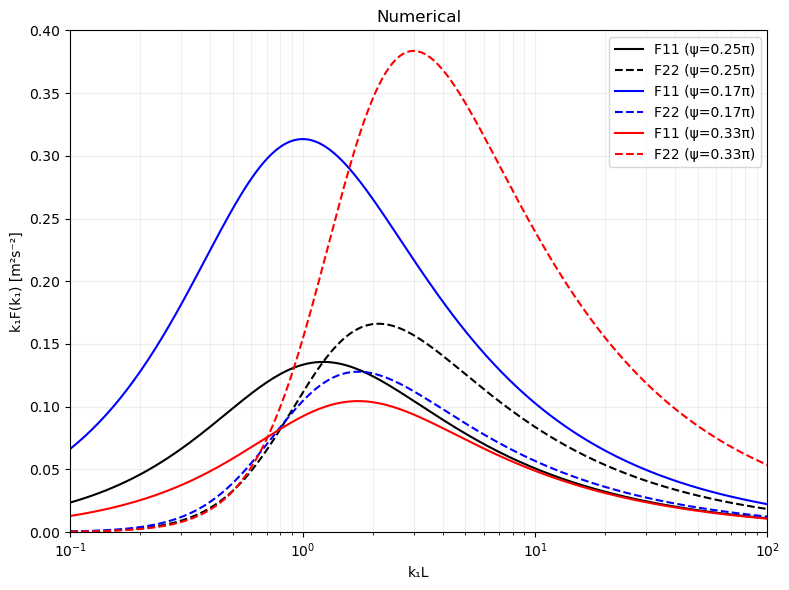

In [6]:
plt.clf(); plt.close('all');

# Generate k1L range (x-axis)
k1L = np.logspace(-1, 2, 200)

# Set parameters
L_2D = 1.0  # Length scale
sigma_squared = 1.0  # Variance

# Define anisotropy parameters
psi_values = {
    "isotropic": np.pi / 4,  # Black lines
    "sigma11_lt_sigma22": np.pi / 6,  # Blue lines
    "sigma11_gt_sigma22": np.pi / 3,  # Red lines
}

# Create figure
plt.figure(figsize=(8, 6))

# Plot spectra for each psi value
colors = {"isotropic": "k", "sigma11_lt_sigma22": "b", "sigma11_gt_sigma22": "r"}

###############################################################
# Plot analytical values
for case, psi in psi_values.items():
    # Calculate normalized spectra
    k1F11 = [kk * eq16_numerical_F11_2D(kk / L_2D, sigma_squared, L_2D, psi)[0] for kk in k1L]
    k1F22 = [kk * eq17_numerical_F22_2D(kk / L_2D, sigma_squared, L_2D, psi)[0] for kk in k1L]

    # Plot F11 (solid) and F22 (dashed)
    plt.plot(k1L, k1F11, color=colors[case], linestyle="-", label=f"F11 (ψ={psi/np.pi:.2f}π)")
    plt.plot(k1L, k1F22, color=colors[case], linestyle="--", label=f"F22 (ψ={psi/np.pi:.2f}π)")

# Set plot properties
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Set axis limits to match the paper
plt.xlim(1e-1, 1e2)
plt.ylim(0, 0.4)

plt.title("Numerical")
plt.tight_layout()

plt.show()

Average difference for F11: 0.0000000000
Average difference for F22: 0.0000000000
Max difference for averaged F11: 0.0000000003
Max difference for averaged F22: 0.0000000014
L2 norm for averaged F11: 0.0000000004
L2 norm for averaged F22: 0.0000000017


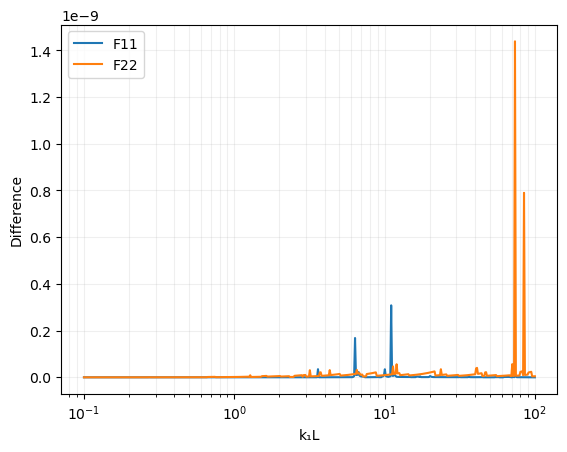

In [7]:
"""
This cell obtains the difference between the numerical and analytical results.
"""
sigma_squared = 1.0
L_2D = 1.0

psi_values = [np.pi / 4, np.pi / 6, np.pi / 3]

k1L = np.logspace(-1, 2, 500)

###########################################3
# Calculate the difference for F11 and F22 for each psi value then averages
k1F11_difference_average = np.zeros(len(k1L))
k1F22_difference_average = np.zeros(len(k1L))

for psi in psi_values:
    k1F11_analytical, k1F22_analytical = get_normalized_spectra(k1L / L_2D, sigma_squared, L_2D, psi)
    k1F11_analytical = np.array(k1F11_analytical)
    k1F22_analytical = np.array(k1F22_analytical)

    k1F11_numerical = np.array([kk * eq16_numerical_F11_2D(kk / L_2D, sigma_squared, L_2D, psi)[0] for kk in k1L])
    k1F22_numerical = np.array([kk * eq17_numerical_F22_2D(kk / L_2D, sigma_squared, L_2D, psi)[0] for kk in k1L])

    k1F11_difference = np.abs(k1F11_numerical - k1F11_analytical)
    k1F22_difference = np.abs(k1F22_numerical - k1F22_analytical)

    k1F11_difference_average += k1F11_difference
    k1F22_difference_average += k1F22_difference

k1F11_difference_average /= len(psi_values)
k1F22_difference_average /= len(psi_values)

###########################################3
# Print some basic stats
print(f"Average difference for F11: {np.mean(k1F11_difference_average):.10f}")
print(f"Average difference for F22: {np.mean(k1F22_difference_average):.10f}")

print(f"Max difference for averaged F11: {np.max(k1F11_difference_average):.10f}")
print(f"Max difference for averaged F22: {np.max(k1F22_difference_average):.10f}")

print(f"L2 norm for averaged F11: {np.linalg.norm(k1F11_difference_average):.10f}")
print(f"L2 norm for averaged F22: {np.linalg.norm(k1F22_difference_average):.10f}")

###########################################3
# Plot 
plt.plot(k1L, k1F11_difference_average, label="F11")
plt.plot(k1L, k1F22_difference_average, label="F22")
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("Difference")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()



# Applying same methodology for simulation Eq 6

In [16]:
"""
The equations from this point on reference the simulation paper.
"""

def E_kappa(kappa: float, L2D: float, c: float) -> float:
    """
    Calculates the energy spectrum in terms of kappa = sqrt(2(k1^2cos^2psi + k2^2sin^2psi))
    """
    numerator = c * (kappa**3)
    denominator = (L2D**(-2) + kappa**2)**(7/3)

    return numerator / denominator

def E_kappa_attenuated(kappa: float, L2D: float, z_i: float, c: float) -> float:
    """
    Attenuated energy spectrum in terms of kappa
    """
    return E_kappa(kappa, L2D, c) / (1 + (kappa * z_i)**2)


# Eq 6 implementation

In [10]:
def __spectral_tensor_common(kappa: float, L2D: float, z_i: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component
    """
    energy = E_kappa_attenuated(kappa, L2D, z_i, c)

    denom = (np.pi * kappa) if not use_k else (np.pi * k)

    return energy / denom

def __spectral_tensor_unattenuated_common(kappa: float, L2D: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component

    This is for the unattenuated energy spectrum
    """
    energy = E_kappa(kappa, L2D, c)

    denom = (np.pi * kappa) if not use_k else (np.pi * k)

    return energy / denom


def sim_spectral_tensor_11(
    k1: float,
    k2: float,
    L2D: float,
    z_i: float,
    c: float,
    psi: float,
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 11 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(
        kappa, L2D, z_i, c, k, use_k
    ) if attenuated else __spectral_tensor_unattenuated_common(
        kappa, L2D, c, k, use_k
    )

    parenthetical = 1 - (k1 / kappa)**2 if not use_k else 1 - (k1 / k)**2

    return leading_factor * parenthetical


def sim_spectral_tensor_22(
    k1: float, 
    k2: float, 
    L2D: float, 
    z_i: float, 
    c: float, 
    psi: float, 
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 22 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(kappa, L2D, z_i, c, k, use_k) if attenuated else __spectral_tensor_unattenuated_common(kappa, L2D, c, psi)

    parenthetical = 1 - (k1 / kappa)**2 if not use_k else 1 - (k2 / k)**2

    return leading_factor * parenthetical


In [11]:
import warnings


def eq6_numerical_F11_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F11
    """

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")

        res, err = integrate.quad(
            lambda k2: sim_spectral_tensor_11(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
            -np.inf, np.inf,
        )

        if len(w) > 0:
            print(f"Warning occured for F11 with k1={k1}, psi={psi}, L2D={L2D}, z_i={z_i}, c={c}, use_k={use_k}, attenuated={attenuated}: {w[0].message}")

            test_k2_values = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

            for k2 in test_k2_values:
                print(f"k2={k2}, sim_spectral_tensor_11(k1, k2, L2D, z_i, c, psi, attenuated, use_k): {sim_spectral_tensor_11(k1, k2, L2D, z_i, c, psi, attenuated, use_k)}")


    return res, err

def eq6_numerical_F22_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F22
    """

    res, err = integrate.quad(
        lambda k2: sim_spectral_tensor_22(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
        -np.inf, np.inf,
    )

    return res, err


# Recreate Figure 1 (Simulation paper)

This is attenuated energy spectrum vs. unattenuated energy spectrum

Average error with attenuation: 0.0000000004
Average error without attenuation: 0.0000000037
Max error with attenuation: 0.0000000004
Max error without attenuation: 0.0000000037
L2 norm with attenuation: 0.0000000004
L2 norm without attenuation: 0.0000000037


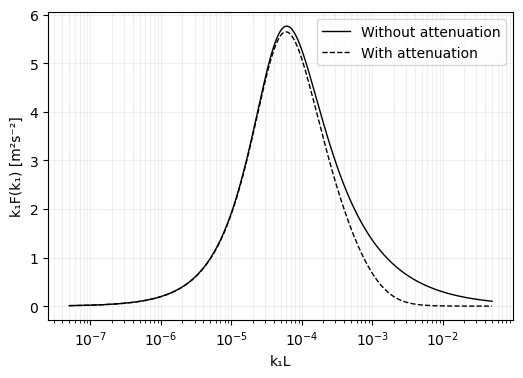

In [ ]:
"""
This cell aims to recreate Figure 1 in the theory paper.
"""

plt.clf(); plt.close('all');

L2D = 20_000 # km
z_i = 500 # m
psi = np.deg2rad(43)

c = 5e-3

k1L = np.logspace(-3, 3, 400) / L2D

############################################
# Collect the two arrays and resp errors

atten_err_list = []
unatten_err_list = []

numerical_F11_attenuated = []
numerical_F11_unattenuated = []

for k1 in k1L:
    atten_res, atten_err = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    unatten_res, unatten_err = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=False, use_k=True)

    atten_err_list.append(atten_err)
    unatten_err_list.append(unatten_err)

    numerical_F11_attenuated.append(k1 * atten_res)
    numerical_F11_unattenuated.append(k1 * unatten_res)

############################################
# Print some basic stats for the integration errors

print(f"Average error with attenuation: {np.mean(atten_err):.10f}")
print(f"Average error without attenuation: {np.mean(unatten_err):.10f}")

print(f"Max error with attenuation: {np.max(atten_err):.10f}")
print(f"Max error without attenuation: {np.max(unatten_err):.10f}")

print(f"L2 norm with attenuation: {np.linalg.norm(atten_err):.10f}")
print(f"L2 norm without attenuation: {np.linalg.norm(unatten_err):.10f}")

############################################
# Plot

plt.figure(figsize=(6, 4))

plt.plot(k1L, numerical_F11_unattenuated, "-", color="black", label="Without attenuation", linewidth=1)
plt.plot(k1L, numerical_F11_attenuated, "--", color="black", label="With attenuation", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

# Recreate Figure 2 (target curves)

The aim of the below cell is to recreate Figure 2 in the theory paper.

This is the target curves for the one-point spectra for F11 and F22 respectively on two domains
- Part (a) is on $40L_{2D}$ 
- Part (b) is on $100L_{2D}$

The actual plot compares these against 10 realizations of the simulated spectra on these domains.

Average error for (a) F11: 0.0000154762
Average error for (a) F22: 153.2881011141
Max error for (a) F11: 0.0001365742
Max error for (a) F22: 5053.0830650185
L2 norm for (a) F11: 0.0007123442
L2 norm for (a) F22: 13920.9918304961


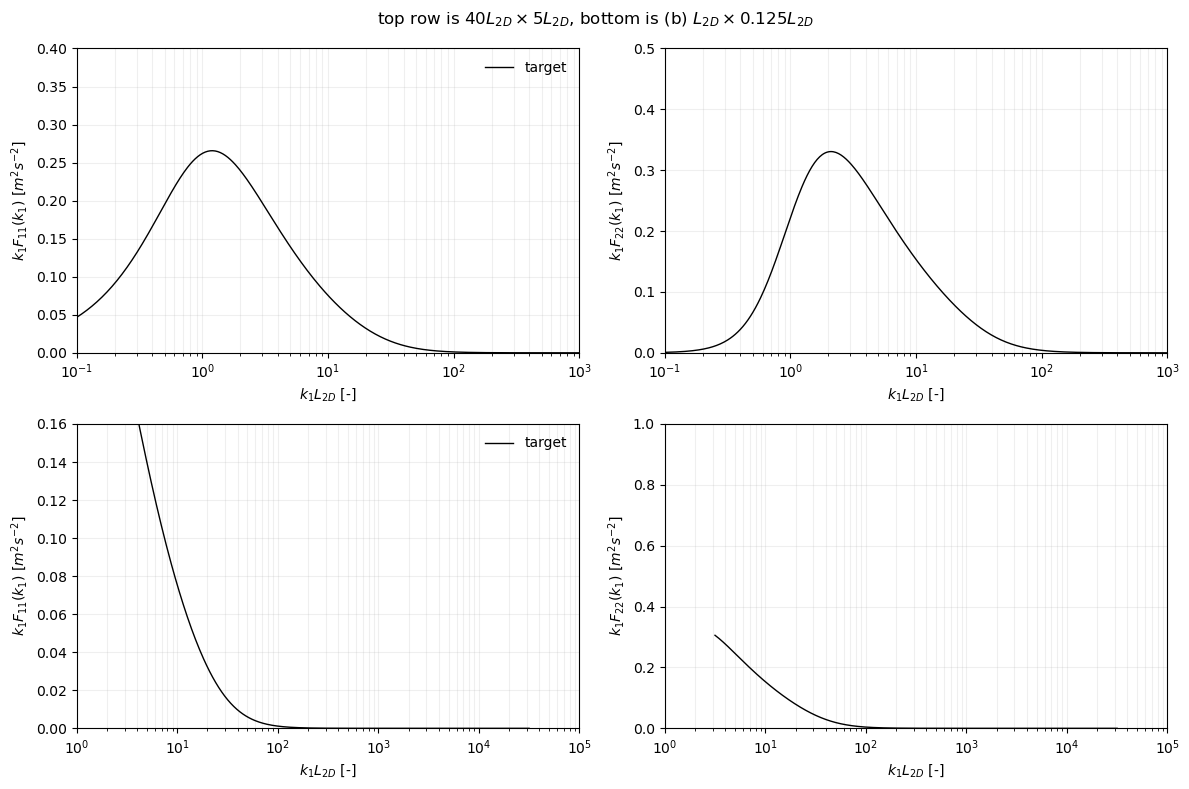

In [30]:
plt.clf(); plt.close('all');

# Parameters
L2D = 20_000 # m
sigma2 = 2 # (m/s)^2
z_i = 500 # m
psi = np.deg2rad(45)

c = (8 * sigma2) / (9 * (L2D**(2/3)))

warnings.filterwarnings("ignore")

########################################################################
# Domain setup


# grab subplots, then helper for subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

def setup_subplots(ax, ylim, is_F11 = True, is_a = True):
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="-", alpha=0.2)
    ax.set_xlabel("$k_1 L_{2D}$ [-]")
    ax.set_ylabel("$k_1 F(k_1)$ [m²s⁻²]")

    if is_F11:
        ax.set_ylabel("$k_1 F_{11}(k_1)$ $[m^2s^{-2}]$")
    else:
        ax.set_ylabel("$k_1 F_{22}(k_1)$ $[m^2s^{-2}]$")

    if is_a:
        ax.set_xlim(1e-1, 1e3)
    else:
        ax.set_xlim(1e0, 1e5)

    ax.set_ylim(0, ylim)

#######################################################################
# (a) Top plots - 40L2D x 4L2D domain

k1_arr_a = np.logspace(-1, 3, 400) / L2D


# Collect the arrays
numerical_F11_a = []
numerical_F22_a = []

numerical_F11_err_a = []
numerical_F22_err_a = []

for k1 in k1_arr_a:
    f11_res, f11_err = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, f22_err = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_a.append(k1 * f11_res)
    numerical_F22_a.append(k1 * f22_res)

    numerical_F11_err_a.append(f11_err)
    numerical_F22_err_a.append(f22_err)


# Print error stats
print(f"Average error for (a) F11: {np.mean(numerical_F11_err_a):.10f}")
print(f"Average error for (a) F22: {np.mean(numerical_F22_err_a):.10f}")

print(f"Max error for (a) F11: {np.max(numerical_F11_err_a):.10f}")
print(f"Max error for (a) F22: {np.max(numerical_F22_err_a):.10f}")

print(f"L2 norm for (a) F11: {np.linalg.norm(numerical_F11_err_a):.10f}")
print(f"L2 norm for (a) F22: {np.linalg.norm(numerical_F22_err_a):.10f}")

ax1.plot(k1_arr_a * L2D, numerical_F11_a, "-", color="black", label="target", linewidth=1)
setup_subplots(ax1, 0.4, is_F11=True, is_a=True)
ax1.legend(frameon=False)

ax2.plot(k1_arr_a * L2D, numerical_F22_a, "-", color="black", label="target", linewidth=1)
setup_subplots(ax2, 0.5, is_F11=False, is_a=True)

#######################################################################
# (b) Bottom plots - L2D x 0.125L2D domain

k1_arr_b = np.logspace(0.5, 4.5, 400) / L2D
numerical_F11_b = []
numerical_F22_b = []

for k1 in k1_arr_b:
    f11_res, _ = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, _ = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_b.append(k1 * f11_res)
    numerical_F22_b.append(k1 * f22_res)

ax3.plot(k1_arr_b * L2D, numerical_F11_b, "-", color="black", label="target", linewidth=1)
setup_subplots(ax3, 0.16, is_F11=True, is_a=False)
ax3.legend(frameon=False)

ax4.plot(k1_arr_b * L2D, numerical_F22_b, "-", color="black", label="target", linewidth=1)
setup_subplots(ax4, 1.0, is_F11=False, is_a=False)

#########################################################################
# Overall plot edits
fig.suptitle(r"top row is $40L_{2D}\times 5L_{2D}$, bottom is (b) $L_{2D} \times 0.125L_{2D}$", y=0.98)
plt.tight_layout()
plt.show()

warnings.filterwarnings("default")


# Debugging

obtained c val:  0.0024128156591954734
Average error for (a) F11: 0.0000000004
Max error for (a) F11: 0.0000000121
L2 norm for (a) F11: 0.0000000296


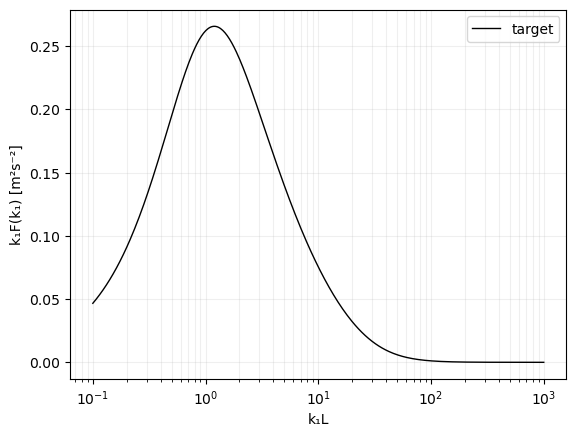

In [ ]:
# TODO: prop the fix on the multiplication to the other plots/rest of code 

plt.clf(); plt.close('all');

# Parameters
L2D_ = 20_000 # m
sigma2_ = 2 # (m/s)^2
z_i_ = 500 # m
psi_ = np.deg2rad(45)

c_ = (8 * sigma2_) / (9 * (L2D_**(2/3)))
print("obtained c val: ", c_)

# Collect the arrays
numerical_F11 = []
numerical_F11_err = []

k1_arr = np.logspace(-1, 3, 400) / L2D_

for k1 in k1_arr:
    f11_res, f11_err = eq6_numerical_F11_2D(k1, psi_, L2D_, z_i_, c_, attenuated=True, use_k=True)

    numerical_F11.append(k1 * f11_res)
    numerical_F11_err.append(f11_err)

# Print basic error statistics
print(f"Average error for (a) F11: {np.mean(numerical_F11_err_a):.10f}")

print(f"Max error for (a) F11: {np.max(numerical_F11_err_a):.10f}")

print(f"L2 norm for (a) F11: {np.linalg.norm(numerical_F11_err_a):.10f}")

# Plot
plt.plot(k1L, numerical_F11, "-", color="black", label="target", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()



In [26]:
from scipy.special import hyp2f1

p = 1

print(hyp2f1(5/6, 1, 1/2, p))
print(hyp2f1(-1/6, 1, 1/2, p), "\n")


k1 = 1e-5
L = 20_000.0
z = 500.0
psi = np.deg2rad(45)

a = 1 + 2 * (k1 * L * np.cos(psi))**2
b = 1 + 2 * (k1 * z * np.cos(psi))**2

print(a)
print(b)

p = (L**2 * b) / (z**2 * a)

print(p)


inf
inf
1.04
1.000025
1538.5
